<a href="https://colab.research.google.com/github/mbraihan/MA_2/blob/main/COMP_6321_MA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 1**

*In this question, you will explore the concept of Transfer Learning (TL) using PyTorch. TL is a technique in which previously trained models can be used to help train new models. There are two possible ways to implemented TL, namely Fine-tuning and Feature Extraction. You can read more about these methods by referring to PyTorch documentations. For the following questions, you are to use the Brain Tumor classification dataset available on Kaggle. Sample images are shown below for the 4 different classes.*

**Download data**

In [ ]:
!gdown 1O6oyF3k8F0R7JHruOWdgbyaRUq6FELR2
!unzip /content/brain_tumor.zip

Downloading...
From: https://drive.google.com/uc?id=1O6oyF3k8F0R7JHruOWdgbyaRUq6FELR2
To: /content/brain_tumor.zip
100% 62.3M/62.3M [00:01<00:00, 38.0MB/s]
Archive:  /content/brain_tumor.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Data/glioma_tumor/G_115.jp

##### *Import libraries*

In [ ]:
import os
import numpy as np
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import shutil
import random
from tqdm import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

##### *(a)*

*Analyze and visualize the statistics of the dataset. Pre-process the data and prepare them for the training phase. Ensure that the images are resized to $224 \times 224 \times 3$ and normalized. Split the data randomly into train and test sets, with a ratio of $7: 3$.*

**Load the data, Split the data into 70% training and 30% testing**

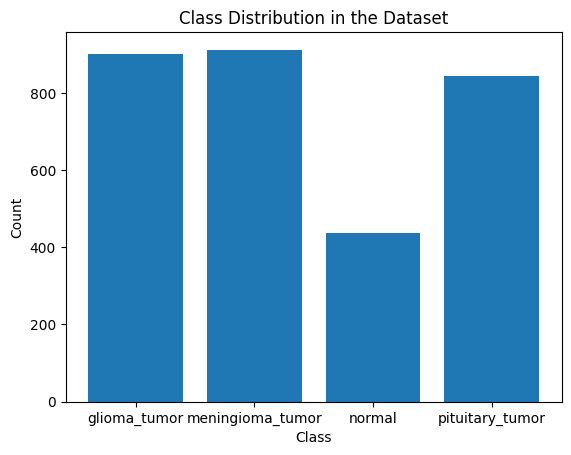

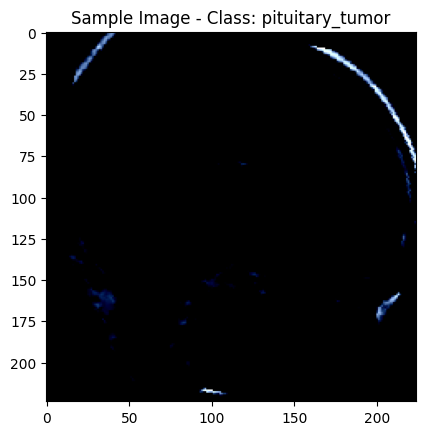

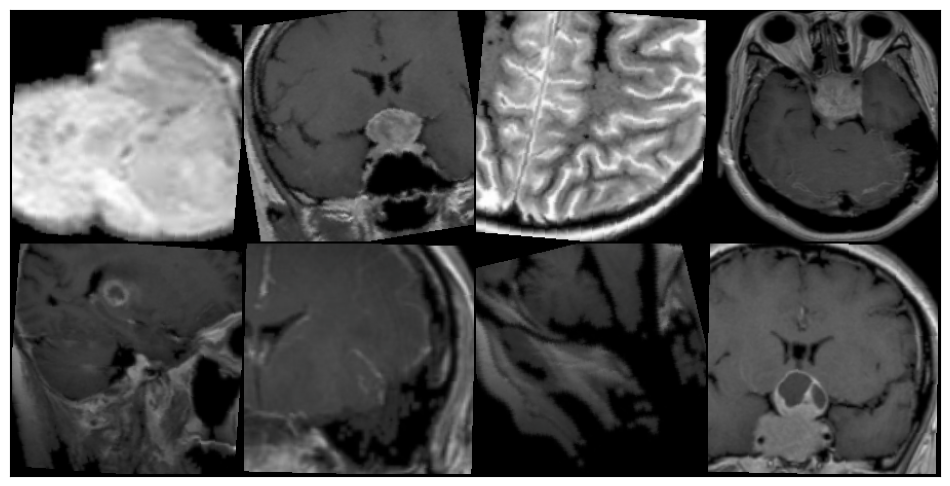

In [ ]:
dataset_path = '/content/Data'


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

# Create a custom dataset
brain_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

batch_size = 64
data_loader = DataLoader(brain_dataset, batch_size=batch_size, shuffle=True)

class_names = brain_dataset.classes

class_counts = torch.bincount(torch.tensor(brain_dataset.targets))
unique_classes = [brain_dataset.classes[i] for i in range(len(class_counts)) if class_counts[i] > 0]

plt.bar(unique_classes, class_counts[class_counts > 0].numpy())
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Split the data into train and test sets (7:3 ratio)
train_indices, test_indices = train_test_split(list(range(len(brain_dataset))), test_size=0.3, random_state=42)

# Split the data into train and test sets (7:3 ratio)
train_size = int(0.7 * len(brain_dataset))
test_size = len(brain_dataset) - train_size
train_dataset, test_dataset = random_split(brain_dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display a sample image
sample_image, sample_label = next(iter(train_loader))
plt.imshow(sample_image[0].permute(1, 2, 0))
plt.title(f'Sample Image - Class: {brain_dataset.classes[sample_label[0]]}')
plt.show()

stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dltrain_loader):
    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:8], nrow=4).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

##### *(b)*

*Train a ResNet-18 model from scratch using the provided dataset for the classification task. You are free to choose the hyperparameters (batch size, learning rate, optimizer, loss function, etc).*

***Model***

In [ ]:
# Load pretrained  ResNet18 model
model = models.resnet18(pretrained=False)

num_classes = len(brain_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print()

***Train***

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Define a variable to store the best validation accuracy
best_acc = 0.0

# Lists to store train and test loss and accuracy
train_loss_list = []
train_accuary_list = []
test_loss_list = []
test_accuary_list = []

# Train model
num_epochs = 50

for epoch in range(num_epochs):
    print("Epoch {} running".format(epoch+1))

    # Training
    model.train()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

        # scheduler.step()

    # Calculate training accuracy
    epoch_train_acc = corrects.double() / total_samples * 100.0
    epoch_train_loss = running_loss / len(train_loader)

    train_loss_list.append(epoch_train_loss)
    train_accuary_list.append(epoch_train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Validation #{epoch+1}")

            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

    # Calculate validation accuracy
    epoch_test_acc = corrects.double() / total_samples * 100.0
    epoch_test_loss = running_loss / len(test_loader)

    test_loss_list.append(epoch_test_loss)
    test_accuary_list.append(epoch_test_acc)

    # Print and save the model with the best test accuracy
    print('[Epoch {}] Training Loss: {:.4f} Acc: {:.4f}% | Validation Loss: {:.4f} Acc: {:.4f}%'.format(
        epoch+1, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc))

    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print('Training complete!')

Epoch 1 running


Validation #1: 100%|██████████| 15/15 [00:08<00:00,  1.75batch/s, accuracy=0.665, loss=0.0133]


[Epoch 1] Training Loss: 0.8201 Acc: 67.1897% | Validation Loss: 0.8264 Acc: 66.5231%
Epoch 2 running


Validation #2: 100%|██████████| 15/15 [00:04<00:00,  3.32batch/s, accuracy=0.652, loss=0.0143]


[Epoch 2] Training Loss: 0.7285 Acc: 71.2044% | Validation Loss: 0.8857 Acc: 65.2314%
Epoch 3 running


Validation #3: 100%|██████████| 15/15 [00:05<00:00,  2.74batch/s, accuracy=0.671, loss=0.0128]


[Epoch 3] Training Loss: 0.6996 Acc: 72.4965% | Validation Loss: 0.7932 Acc: 67.0614%
Epoch 4 running


Validation #4: 100%|██████████| 15/15 [00:04<00:00,  3.28batch/s, accuracy=0.677, loss=0.0127]


[Epoch 4] Training Loss: 0.6524 Acc: 74.6193% | Validation Loss: 0.7886 Acc: 67.7072%
Epoch 5 running


Validation #5: 100%|██████████| 15/15 [00:05<00:00,  2.81batch/s, accuracy=0.729, loss=0.0109]


[Epoch 5] Training Loss: 0.6497 Acc: 74.1117% | Validation Loss: 0.6722 Acc: 72.8741%
Epoch 6 running


Validation #6: 100%|██████████| 15/15 [00:04<00:00,  3.09batch/s, accuracy=0.704, loss=0.0127]


[Epoch 6] Training Loss: 0.6063 Acc: 76.1421% | Validation Loss: 0.7880 Acc: 70.3983%
Epoch 7 running


Validation #7: 100%|██████████| 15/15 [00:05<00:00,  2.84batch/s, accuracy=0.661, loss=0.0129]


[Epoch 7] Training Loss: 0.6045 Acc: 76.1421% | Validation Loss: 0.7991 Acc: 66.0926%
Epoch 8 running


Validation #8: 100%|██████████| 15/15 [00:04<00:00,  3.33batch/s, accuracy=0.712, loss=0.0114]


[Epoch 8] Training Loss: 0.5860 Acc: 76.8805% | Validation Loss: 0.7064 Acc: 71.1518%
Epoch 9 running


Validation #9: 100%|██████████| 15/15 [00:05<00:00,  2.99batch/s, accuracy=0.733, loss=0.0109]


[Epoch 9] Training Loss: 0.5884 Acc: 76.9266% | Validation Loss: 0.6734 Acc: 73.3046%
Epoch 10 running


Validation #10: 100%|██████████| 15/15 [00:04<00:00,  3.38batch/s, accuracy=0.756, loss=0.0104]


[Epoch 10] Training Loss: 0.5631 Acc: 78.9109% | Validation Loss: 0.6439 Acc: 75.5651%
Epoch 11 running


Validation #11: 100%|██████████| 15/15 [00:05<00:00,  2.88batch/s, accuracy=0.734, loss=0.0114]


[Epoch 11] Training Loss: 0.5610 Acc: 77.4342% | Validation Loss: 0.7071 Acc: 73.4123%
Epoch 12 running


Validation #12: 100%|██████████| 15/15 [00:04<00:00,  3.35batch/s, accuracy=0.73, loss=0.0108]


[Epoch 12] Training Loss: 0.5734 Acc: 77.3881% | Validation Loss: 0.6706 Acc: 72.9817%
Epoch 13 running


Validation #13: 100%|██████████| 15/15 [00:05<00:00,  2.74batch/s, accuracy=0.751, loss=0.01]


[Epoch 13] Training Loss: 0.5021 Acc: 80.4799% | Validation Loss: 0.6216 Acc: 75.1346%
Epoch 14 running


Validation #14: 100%|██████████| 15/15 [00:04<00:00,  3.35batch/s, accuracy=0.761, loss=0.0109]


[Epoch 14] Training Loss: 0.5163 Acc: 79.5570% | Validation Loss: 0.6740 Acc: 76.1033%
Epoch 15 running


Validation #15: 100%|██████████| 15/15 [00:05<00:00,  2.68batch/s, accuracy=0.76, loss=0.0104]


[Epoch 15] Training Loss: 0.4969 Acc: 80.8952% | Validation Loss: 0.6438 Acc: 75.9957%
Epoch 16 running


Validation #16: 100%|██████████| 15/15 [00:04<00:00,  3.32batch/s, accuracy=0.767, loss=0.00935]


[Epoch 16] Training Loss: 0.5115 Acc: 80.1108% | Validation Loss: 0.5792 Acc: 76.7492%
Epoch 17 running


Validation #17: 100%|██████████| 15/15 [00:05<00:00,  2.57batch/s, accuracy=0.779, loss=0.00983]


[Epoch 17] Training Loss: 0.4824 Acc: 80.6184% | Validation Loss: 0.6087 Acc: 77.9333%
Epoch 18 running


Validation #18: 100%|██████████| 15/15 [00:07<00:00,  2.12batch/s, accuracy=0.757, loss=0.00981]


[Epoch 18] Training Loss: 0.4679 Acc: 81.3106% | Validation Loss: 0.6078 Acc: 75.6728%
Epoch 19 running


Validation #19: 100%|██████████| 15/15 [00:05<00:00,  2.92batch/s, accuracy=0.761, loss=0.0102]


[Epoch 19] Training Loss: 0.4661 Acc: 81.9566% | Validation Loss: 0.6343 Acc: 76.1033%
Epoch 20 running


Validation #20: 100%|██████████| 15/15 [00:04<00:00,  3.21batch/s, accuracy=0.786, loss=0.00934]


[Epoch 20] Training Loss: 0.4360 Acc: 83.5718% | Validation Loss: 0.5783 Acc: 78.5791%
Epoch 21 running


Validation #21: 100%|██████████| 15/15 [00:06<00:00,  2.43batch/s, accuracy=0.784, loss=0.00968]


[Epoch 21] Training Loss: 0.4500 Acc: 83.0180% | Validation Loss: 0.5993 Acc: 78.3638%
Epoch 22 running


Validation #22: 100%|██████████| 15/15 [00:05<00:00,  2.94batch/s, accuracy=0.737, loss=0.0113]


[Epoch 22] Training Loss: 0.4570 Acc: 81.9105% | Validation Loss: 0.7021 Acc: 73.7352%
Epoch 23 running


Validation #23: 100%|██████████| 15/15 [00:05<00:00,  2.66batch/s, accuracy=0.77, loss=0.00922]


[Epoch 23] Training Loss: 0.4321 Acc: 83.0641% | Validation Loss: 0.5709 Acc: 76.9645%
Epoch 24 running


Validation #24: 100%|██████████| 15/15 [00:07<00:00,  2.06batch/s, accuracy=0.771, loss=0.0101]


[Epoch 24] Training Loss: 0.4488 Acc: 82.7873% | Validation Loss: 0.6253 Acc: 77.0721%
Epoch 25 running


Validation #25: 100%|██████████| 15/15 [00:04<00:00,  3.13batch/s, accuracy=0.808, loss=0.00854]


[Epoch 25] Training Loss: 0.4168 Acc: 83.4333% | Validation Loss: 0.5289 Acc: 80.8396%
Epoch 26 running


Validation #26: 100%|██████████| 15/15 [00:08<00:00,  1.86batch/s, accuracy=0.794, loss=0.00919]


[Epoch 26] Training Loss: 0.4416 Acc: 83.2026% | Validation Loss: 0.5693 Acc: 79.4403%
Epoch 27 running


Validation #27: 100%|██████████| 15/15 [00:07<00:00,  2.04batch/s, accuracy=0.763, loss=0.0101]


[Epoch 27] Training Loss: 0.4092 Acc: 83.6641% | Validation Loss: 0.6249 Acc: 76.3186%
Epoch 28 running


Validation #28: 100%|██████████| 15/15 [00:04<00:00,  3.34batch/s, accuracy=0.792, loss=0.00871]


[Epoch 28] Training Loss: 0.3987 Acc: 84.4947% | Validation Loss: 0.5391 Acc: 79.2250%
Epoch 29 running


Validation #29: 100%|██████████| 15/15 [00:04<00:00,  3.23batch/s, accuracy=0.774, loss=0.00916]


[Epoch 29] Training Loss: 0.3838 Acc: 85.2792% | Validation Loss: 0.5670 Acc: 77.3950%
Epoch 30 running


Validation #30: 100%|██████████| 15/15 [00:04<00:00,  3.20batch/s, accuracy=0.755, loss=0.00996]


[Epoch 30] Training Loss: 0.3858 Acc: 84.3563% | Validation Loss: 0.6169 Acc: 75.4575%
Epoch 31 running


Validation #31: 100%|██████████| 15/15 [00:04<00:00,  3.02batch/s, accuracy=0.774, loss=0.00964]


[Epoch 31] Training Loss: 0.3810 Acc: 84.9562% | Validation Loss: 0.5972 Acc: 77.3950%
Epoch 32 running


Validation #32: 100%|██████████| 15/15 [00:06<00:00,  2.17batch/s, accuracy=0.813, loss=0.008]


[Epoch 32] Training Loss: 0.3753 Acc: 84.6793% | Validation Loss: 0.4955 Acc: 81.2702%
Epoch 33 running


Validation #33: 100%|██████████| 15/15 [00:04<00:00,  3.26batch/s, accuracy=0.819, loss=0.00784]


[Epoch 33] Training Loss: 0.3930 Acc: 83.8025% | Validation Loss: 0.4856 Acc: 81.9160%
Epoch 34 running


Validation #34: 100%|██████████| 15/15 [00:05<00:00,  2.76batch/s, accuracy=0.78, loss=0.0094]


[Epoch 34] Training Loss: 0.3691 Acc: 84.8177% | Validation Loss: 0.5823 Acc: 78.0409%
Epoch 35 running


Validation #35: 100%|██████████| 15/15 [00:04<00:00,  3.16batch/s, accuracy=0.772, loss=0.0114]


[Epoch 35] Training Loss: 0.3684 Acc: 85.1869% | Validation Loss: 0.7038 Acc: 77.1798%
Epoch 36 running


Validation #36: 100%|██████████| 15/15 [00:05<00:00,  2.69batch/s, accuracy=0.806, loss=0.0086]


[Epoch 36] Training Loss: 0.3560 Acc: 86.1098% | Validation Loss: 0.5323 Acc: 80.6243%
Epoch 37 running


Validation #37: 100%|██████████| 15/15 [00:04<00:00,  3.26batch/s, accuracy=0.793, loss=0.00921]


[Epoch 37] Training Loss: 0.3589 Acc: 86.4790% | Validation Loss: 0.5704 Acc: 79.3326%
Epoch 38 running


Validation #38: 100%|██████████| 15/15 [00:09<00:00,  1.62batch/s, accuracy=0.829, loss=0.0071]


[Epoch 38] Training Loss: 0.3709 Acc: 85.3715% | Validation Loss: 0.4400 Acc: 82.8848%
Epoch 39 running


Validation #39: 100%|██████████| 15/15 [00:07<00:00,  2.11batch/s, accuracy=0.778, loss=0.00971]


[Epoch 39] Training Loss: 0.3592 Acc: 86.1560% | Validation Loss: 0.6012 Acc: 77.8256%
Epoch 40 running


Validation #40: 100%|██████████| 15/15 [00:04<00:00,  3.21batch/s, accuracy=0.781, loss=0.00892]


[Epoch 40] Training Loss: 0.3497 Acc: 86.9405% | Validation Loss: 0.5522 Acc: 78.1485%
Epoch 41 running


Validation #41: 100%|██████████| 15/15 [00:05<00:00,  2.84batch/s, accuracy=0.814, loss=0.00871]


[Epoch 41] Training Loss: 0.3393 Acc: 86.6174% | Validation Loss: 0.5397 Acc: 81.3778%
Epoch 42 running


Validation #42: 100%|██████████| 15/15 [00:04<00:00,  3.27batch/s, accuracy=0.827, loss=0.00771]


[Epoch 42] Training Loss: 0.3364 Acc: 87.1712% | Validation Loss: 0.4774 Acc: 82.6695%
Epoch 43 running


Validation #43: 100%|██████████| 15/15 [00:05<00:00,  2.91batch/s, accuracy=0.844, loss=0.00743]


[Epoch 43] Training Loss: 0.3339 Acc: 87.1712% | Validation Loss: 0.4604 Acc: 84.3918%
Epoch 44 running


Validation #44: 100%|██████████| 15/15 [00:04<00:00,  3.29batch/s, accuracy=0.775, loss=0.00979]


[Epoch 44] Training Loss: 0.3152 Acc: 87.5865% | Validation Loss: 0.6061 Acc: 77.5027%
Epoch 45 running


Validation #45: 100%|██████████| 15/15 [00:05<00:00,  2.80batch/s, accuracy=0.806, loss=0.00877]


[Epoch 45] Training Loss: 0.3156 Acc: 87.4481% | Validation Loss: 0.5434 Acc: 80.6243%
Epoch 46 running


Validation #46: 100%|██████████| 15/15 [00:04<00:00,  3.27batch/s, accuracy=0.828, loss=0.00789]


[Epoch 46] Training Loss: 0.2890 Acc: 89.2478% | Validation Loss: 0.4885 Acc: 82.7772%
Epoch 47 running


Validation #47: 100%|██████████| 15/15 [00:05<00:00,  2.79batch/s, accuracy=0.798, loss=0.009]


[Epoch 47] Training Loss: 0.3461 Acc: 87.5865% | Validation Loss: 0.5572 Acc: 79.7632%
Epoch 48 running


Validation #48: 100%|██████████| 15/15 [00:05<00:00,  2.68batch/s, accuracy=0.817, loss=0.0085]


[Epoch 48] Training Loss: 0.3295 Acc: 87.4942% | Validation Loss: 0.5267 Acc: 81.7008%
Epoch 49 running


Validation #49: 100%|██████████| 15/15 [00:04<00:00,  3.36batch/s, accuracy=0.842, loss=0.0073]


[Epoch 49] Training Loss: 0.3125 Acc: 87.7250% | Validation Loss: 0.4523 Acc: 84.1765%
Epoch 50 running


Validation #50: 100%|██████████| 15/15 [00:05<00:00,  2.64batch/s, accuracy=0.854, loss=0.0067]


[Epoch 50] Training Loss: 0.2952 Acc: 88.4633% | Validation Loss: 0.4147 Acc: 85.3606%
Training complete!


***Plotting***

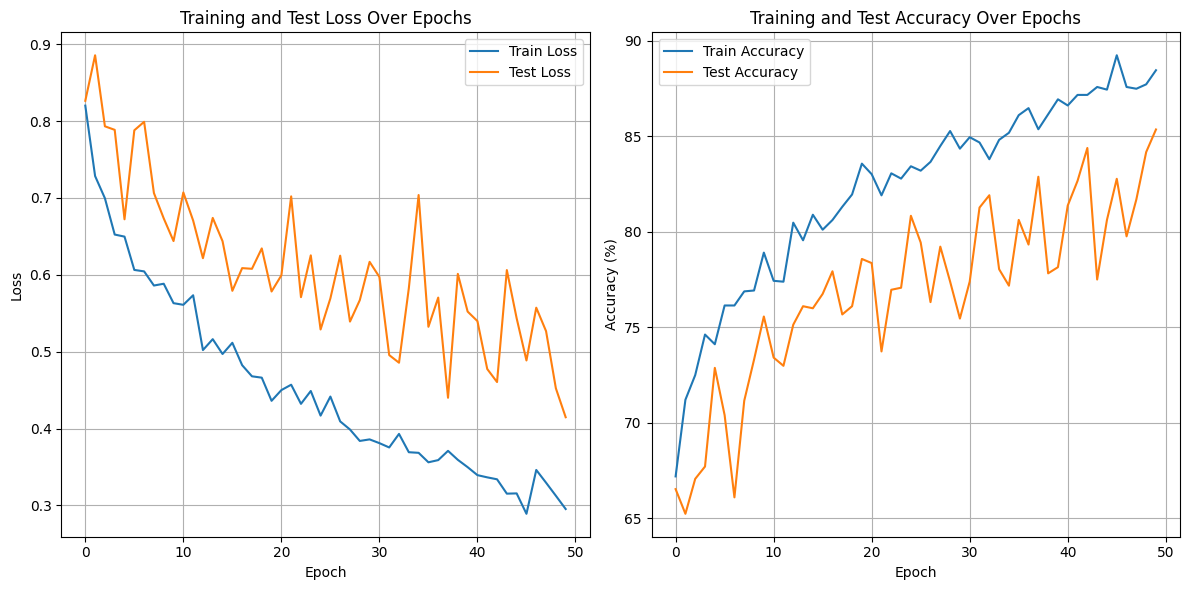

In [ ]:
train_accuary_np = [x.cpu().numpy() for x in train_accuary_list]
test_accuary_np = [x.cpu().numpy() for x in test_accuary_list]

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuary_np, label='Train Accuracy')
plt.plot(test_accuary_np, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

***Model Evaluation***

In [ ]:
y_true = []
y_pred = []

for data in test_loader:
    image,label=data[0].to(device),data[1]
    y_true.extend(label.numpy())

    outputs=model(image)

    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy())

***Confusion matrix and Classification Reports***

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       266
           1       0.73      0.83      0.78       277
           2       0.83      0.82      0.83       151
           3       0.87      0.85      0.86       235

    accuracy                           0.82       929
   macro avg       0.83      0.82      0.83       929
weighted avg       0.83      0.82      0.82       929



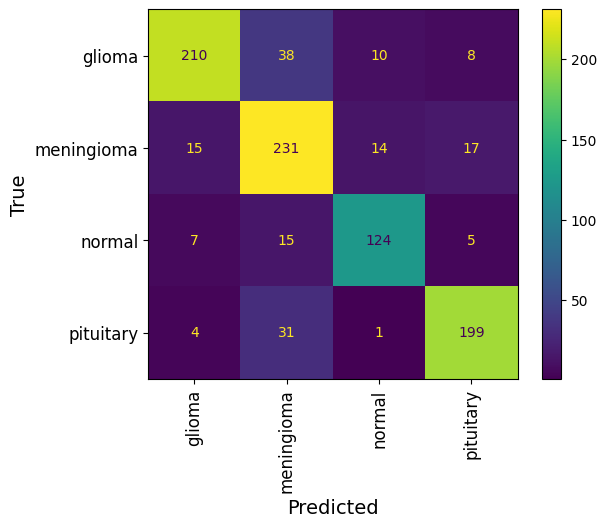

In [ ]:
class_labels = ['glioma', 'meningioma', 'normal', 'pituitary']

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

sns.set_palette("viridis")

disp.plot(cmap=plt.cm.viridis, values_format='.4g', xticks_rotation="vertical", ax=plt.gca())

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)

print(classification_report(y_true, y_pred))

plt.show()

##### *(c)*

*Train another ResNet-18 model using the fine-tuning TL method based on IMAGENET1K weights. You should use the same hyperparameters and same data used to train the previous ResNet-18 model.*

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Lists to store train and test loss and accuracy
train_loss_list = []
train_accuary_list = []
test_loss_list = []
test_accuary_list = []

# Train model
num_epochs = 50

for epoch in range(num_epochs):
    print("Epoch {} running".format(epoch+1))

    # Training
    model.train()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

        # scheduler.step()

    # Calculate training accuracy
    epoch_train_acc = corrects.double() / total_samples * 100.0
    epoch_train_loss = running_loss / len(train_loader)

    train_loss_list.append(epoch_train_loss)
    train_accuary_list.append(epoch_train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Validation #{epoch+1}")

            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

    # Calculate validation accuracy
    epoch_test_acc = corrects.double() / total_samples * 100.0
    epoch_test_loss = running_loss / len(test_loader)

    test_loss_list.append(epoch_test_loss)
    test_accuary_list.append(epoch_test_acc)

    # Print and save the model with the best validation accuracy
    print('[Epoch {}] Training Loss: {:.4f} Acc: {:.4f}% | Validation Loss: {:.4f} Acc: {:.4f}%'.format(
        epoch+1, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc))

    # Save the model with the best validation accuracy
    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        torch.save(model.state_dict(), 'best_model_imagenet.pth')

print('Training complete!')

Epoch 1 running


Validation #1: 100%|██████████| 15/15 [00:05<00:00,  2.94batch/s, accuracy=0.615, loss=0.0145]


[Epoch 1] Training Loss: 0.8371 Acc: 64.5132% | Validation Loss: 0.8957 Acc: 61.4639%
Epoch 2 running


Validation #2: 100%|██████████| 15/15 [00:04<00:00,  3.28batch/s, accuracy=0.825, loss=0.00773]


[Epoch 2] Training Loss: 0.4962 Acc: 81.4952% | Validation Loss: 0.4790 Acc: 82.4543%
Epoch 3 running


Validation #3: 100%|██████████| 15/15 [00:05<00:00,  2.78batch/s, accuracy=0.822, loss=0.00733]


[Epoch 3] Training Loss: 0.4116 Acc: 84.4024% | Validation Loss: 0.4540 Acc: 82.2390%
Epoch 4 running


Validation #4: 100%|██████████| 15/15 [00:04<00:00,  3.20batch/s, accuracy=0.84, loss=0.00713]


[Epoch 4] Training Loss: 0.3642 Acc: 86.6174% | Validation Loss: 0.4414 Acc: 83.9612%
Epoch 5 running


Validation #5: 100%|██████████| 15/15 [00:05<00:00,  2.79batch/s, accuracy=0.876, loss=0.00601]


[Epoch 5] Training Loss: 0.3176 Acc: 87.9557% | Validation Loss: 0.3725 Acc: 87.6211%
Epoch 6 running


Validation #6: 100%|██████████| 15/15 [00:04<00:00,  3.29batch/s, accuracy=0.857, loss=0.00618]


[Epoch 6] Training Loss: 0.2767 Acc: 89.2478% | Validation Loss: 0.3829 Acc: 85.6835%
Epoch 7 running


Validation #7: 100%|██████████| 15/15 [00:05<00:00,  2.70batch/s, accuracy=0.845, loss=0.00656]


[Epoch 7] Training Loss: 0.2819 Acc: 89.4785% | Validation Loss: 0.4062 Acc: 84.4995%
Epoch 8 running


Validation #8: 100%|██████████| 15/15 [00:04<00:00,  3.23batch/s, accuracy=0.875, loss=0.00555]


[Epoch 8] Training Loss: 0.2529 Acc: 90.2169% | Validation Loss: 0.3437 Acc: 87.5135%
Epoch 9 running


Validation #9: 100%|██████████| 15/15 [00:05<00:00,  2.72batch/s, accuracy=0.89, loss=0.00487]


[Epoch 9] Training Loss: 0.2396 Acc: 91.1860% | Validation Loss: 0.3016 Acc: 89.0205%
Epoch 10 running


Validation #10: 100%|██████████| 15/15 [00:04<00:00,  3.24batch/s, accuracy=0.878, loss=0.00553]


[Epoch 10] Training Loss: 0.2001 Acc: 92.8934% | Validation Loss: 0.3424 Acc: 87.8364%
Epoch 11 running


Validation #11: 100%|██████████| 15/15 [00:05<00:00,  2.69batch/s, accuracy=0.89, loss=0.00495]


[Epoch 11] Training Loss: 0.2315 Acc: 91.2783% | Validation Loss: 0.3067 Acc: 89.0205%
Epoch 12 running


Validation #12: 100%|██████████| 15/15 [00:04<00:00,  3.26batch/s, accuracy=0.886, loss=0.00573]


[Epoch 12] Training Loss: 0.2088 Acc: 92.1089% | Validation Loss: 0.3549 Acc: 88.5899%
Epoch 13 running


Validation #13: 100%|██████████| 15/15 [00:05<00:00,  2.67batch/s, accuracy=0.881, loss=0.00518]


[Epoch 13] Training Loss: 0.1882 Acc: 92.7088% | Validation Loss: 0.3211 Acc: 88.0517%
Epoch 14 running


Validation #14: 100%|██████████| 15/15 [00:04<00:00,  3.26batch/s, accuracy=0.888, loss=0.00478]


[Epoch 14] Training Loss: 0.2199 Acc: 91.5551% | Validation Loss: 0.2961 Acc: 88.8052%
Epoch 15 running


Validation #15: 100%|██████████| 15/15 [00:05<00:00,  2.65batch/s, accuracy=0.891, loss=0.00497]


[Epoch 15] Training Loss: 0.1721 Acc: 93.8163% | Validation Loss: 0.3079 Acc: 89.1281%
Epoch 16 running


Validation #16: 100%|██████████| 15/15 [00:04<00:00,  3.26batch/s, accuracy=0.888, loss=0.00497]


[Epoch 16] Training Loss: 0.1818 Acc: 93.0318% | Validation Loss: 0.3079 Acc: 88.8052%
Epoch 17 running


Validation #17: 100%|██████████| 15/15 [00:05<00:00,  2.56batch/s, accuracy=0.895, loss=0.00513]


[Epoch 17] Training Loss: 0.1638 Acc: 93.5395% | Validation Loss: 0.3174 Acc: 89.4510%
Epoch 18 running


Validation #18: 100%|██████████| 15/15 [00:04<00:00,  3.28batch/s, accuracy=0.889, loss=0.00483]


[Epoch 18] Training Loss: 0.1691 Acc: 93.8625% | Validation Loss: 0.2993 Acc: 88.9128%
Epoch 19 running


Validation #19: 100%|██████████| 15/15 [00:05<00:00,  2.64batch/s, accuracy=0.884, loss=0.00551]


[Epoch 19] Training Loss: 0.1518 Acc: 94.8316% | Validation Loss: 0.3410 Acc: 88.3746%
Epoch 20 running


Validation #20: 100%|██████████| 15/15 [00:04<00:00,  3.14batch/s, accuracy=0.893, loss=0.00503]


[Epoch 20] Training Loss: 0.1532 Acc: 94.6470% | Validation Loss: 0.3117 Acc: 89.3434%
Epoch 21 running


Validation #21: 100%|██████████| 15/15 [00:05<00:00,  2.64batch/s, accuracy=0.9, loss=0.00487]


[Epoch 21] Training Loss: 0.1613 Acc: 93.5395% | Validation Loss: 0.3018 Acc: 89.9892%
Epoch 22 running


Validation #22: 100%|██████████| 15/15 [00:04<00:00,  3.23batch/s, accuracy=0.871, loss=0.00604]


[Epoch 22] Training Loss: 0.1463 Acc: 93.9548% | Validation Loss: 0.3738 Acc: 87.0829%
Epoch 23 running


Validation #23: 100%|██████████| 15/15 [00:05<00:00,  2.66batch/s, accuracy=0.899, loss=0.00482]


[Epoch 23] Training Loss: 0.1329 Acc: 95.1546% | Validation Loss: 0.2983 Acc: 89.8816%
Epoch 24 running


Validation #24: 100%|██████████| 15/15 [00:04<00:00,  3.28batch/s, accuracy=0.902, loss=0.00458]


[Epoch 24] Training Loss: 0.1313 Acc: 94.7854% | Validation Loss: 0.2839 Acc: 90.2045%
Epoch 25 running


Validation #25: 100%|██████████| 15/15 [00:05<00:00,  2.68batch/s, accuracy=0.904, loss=0.00431]


[Epoch 25] Training Loss: 0.1387 Acc: 95.2007% | Validation Loss: 0.2669 Acc: 90.4198%
Epoch 26 running


Validation #26: 100%|██████████| 15/15 [00:04<00:00,  3.25batch/s, accuracy=0.897, loss=0.00489]


[Epoch 26] Training Loss: 0.1236 Acc: 95.7084% | Validation Loss: 0.3029 Acc: 89.6663%
Epoch 27 running


Validation #27: 100%|██████████| 15/15 [00:05<00:00,  2.62batch/s, accuracy=0.901, loss=0.00425]


[Epoch 27] Training Loss: 0.1080 Acc: 96.0314% | Validation Loss: 0.2631 Acc: 90.0969%
Epoch 28 running


Validation #28: 100%|██████████| 15/15 [00:04<00:00,  3.29batch/s, accuracy=0.917, loss=0.00448]


[Epoch 28] Training Loss: 0.1350 Acc: 95.1084% | Validation Loss: 0.2775 Acc: 91.7115%
Epoch 29 running


Validation #29: 100%|██████████| 15/15 [00:05<00:00,  2.66batch/s, accuracy=0.892, loss=0.00468]


[Epoch 29] Training Loss: 0.1082 Acc: 95.5699% | Validation Loss: 0.2896 Acc: 89.2357%
Epoch 30 running


Validation #30: 100%|██████████| 15/15 [00:04<00:00,  3.31batch/s, accuracy=0.889, loss=0.00604]


[Epoch 30] Training Loss: 0.1321 Acc: 95.0162% | Validation Loss: 0.3743 Acc: 88.9128%
Epoch 31 running


Validation #31: 100%|██████████| 15/15 [00:05<00:00,  2.65batch/s, accuracy=0.886, loss=0.00477]


[Epoch 31] Training Loss: 0.1186 Acc: 95.3392% | Validation Loss: 0.2956 Acc: 88.5899%
Epoch 32 running


Validation #32: 100%|██████████| 15/15 [00:04<00:00,  3.28batch/s, accuracy=0.862, loss=0.00681]


[Epoch 32] Training Loss: 0.1466 Acc: 94.4624% | Validation Loss: 0.4221 Acc: 86.2217%
Epoch 33 running


Validation #33: 100%|██████████| 15/15 [00:05<00:00,  2.61batch/s, accuracy=0.901, loss=0.00504]


[Epoch 33] Training Loss: 0.1151 Acc: 95.6161% | Validation Loss: 0.3122 Acc: 90.0969%
Epoch 34 running


Validation #34: 100%|██████████| 15/15 [00:04<00:00,  3.28batch/s, accuracy=0.913, loss=0.00424]


[Epoch 34] Training Loss: 0.1130 Acc: 96.0775% | Validation Loss: 0.2625 Acc: 91.2809%
Epoch 35 running


Validation #35: 100%|██████████| 15/15 [00:05<00:00,  2.64batch/s, accuracy=0.889, loss=0.00517]


[Epoch 35] Training Loss: 0.1322 Acc: 94.6008% | Validation Loss: 0.3204 Acc: 88.9128%
Epoch 36 running


Validation #36: 100%|██████████| 15/15 [00:04<00:00,  3.22batch/s, accuracy=0.909, loss=0.00477]


[Epoch 36] Training Loss: 0.1124 Acc: 95.4776% | Validation Loss: 0.2956 Acc: 90.8504%
Epoch 37 running


Validation #37: 100%|██████████| 15/15 [00:05<00:00,  2.57batch/s, accuracy=0.909, loss=0.00495]


[Epoch 37] Training Loss: 0.1253 Acc: 95.2007% | Validation Loss: 0.3064 Acc: 90.8504%
Epoch 38 running


Validation #38: 100%|██████████| 15/15 [00:04<00:00,  3.30batch/s, accuracy=0.879, loss=0.00633]


[Epoch 38] Training Loss: 0.1133 Acc: 96.0314% | Validation Loss: 0.3923 Acc: 87.9440%
Epoch 39 running


Validation #39: 100%|██████████| 15/15 [00:05<00:00,  2.63batch/s, accuracy=0.899, loss=0.00425]


[Epoch 39] Training Loss: 0.1126 Acc: 95.7545% | Validation Loss: 0.2633 Acc: 89.8816%
Epoch 40 running


Validation #40: 100%|██████████| 15/15 [00:04<00:00,  3.29batch/s, accuracy=0.913, loss=0.0043]


[Epoch 40] Training Loss: 0.1000 Acc: 96.3544% | Validation Loss: 0.2664 Acc: 91.2809%
Epoch 41 running


Validation #41: 100%|██████████| 15/15 [00:05<00:00,  2.65batch/s, accuracy=0.887, loss=0.00486]


[Epoch 41] Training Loss: 0.1210 Acc: 95.6622% | Validation Loss: 0.3012 Acc: 88.6975%
Epoch 42 running


Validation #42: 100%|██████████| 15/15 [00:04<00:00,  3.29batch/s, accuracy=0.915, loss=0.00409]


[Epoch 42] Training Loss: 0.1003 Acc: 96.4006% | Validation Loss: 0.2535 Acc: 91.4962%
Epoch 43 running


Validation #43: 100%|██████████| 15/15 [00:05<00:00,  2.66batch/s, accuracy=0.902, loss=0.00514]


[Epoch 43] Training Loss: 0.1139 Acc: 95.8006% | Validation Loss: 0.3182 Acc: 90.2045%
Epoch 44 running


Validation #44: 100%|██████████| 15/15 [00:04<00:00,  3.27batch/s, accuracy=0.913, loss=0.00427]


[Epoch 44] Training Loss: 0.1062 Acc: 95.8929% | Validation Loss: 0.2647 Acc: 91.2809%
Epoch 45 running


Validation #45: 100%|██████████| 15/15 [00:05<00:00,  2.68batch/s, accuracy=0.895, loss=0.00534]


[Epoch 45] Training Loss: 0.0969 Acc: 96.1237% | Validation Loss: 0.3310 Acc: 89.4510%
Epoch 46 running


Validation #46: 100%|██████████| 15/15 [00:04<00:00,  3.22batch/s, accuracy=0.9, loss=0.00535]


[Epoch 46] Training Loss: 0.1113 Acc: 96.1237% | Validation Loss: 0.3316 Acc: 89.9892%
Epoch 47 running


Validation #47: 100%|██████████| 15/15 [00:05<00:00,  2.72batch/s, accuracy=0.911, loss=0.00488]


[Epoch 47] Training Loss: 0.0995 Acc: 96.4006% | Validation Loss: 0.3024 Acc: 91.0657%
Epoch 48 running


Validation #48: 100%|██████████| 15/15 [00:04<00:00,  3.23batch/s, accuracy=0.903, loss=0.00499]


[Epoch 48] Training Loss: 0.1111 Acc: 95.6622% | Validation Loss: 0.3092 Acc: 90.3122%
Epoch 49 running


Validation #49: 100%|██████████| 15/15 [00:05<00:00,  2.68batch/s, accuracy=0.893, loss=0.00558]


[Epoch 49] Training Loss: 0.0915 Acc: 97.1850% | Validation Loss: 0.3459 Acc: 89.3434%
Epoch 50 running


Validation #50: 100%|██████████| 15/15 [00:04<00:00,  3.21batch/s, accuracy=0.911, loss=0.00396]

[Epoch 50] Training Loss: 0.1005 Acc: 96.2621% | Validation Loss: 0.2456 Acc: 91.0657%
Training complete!


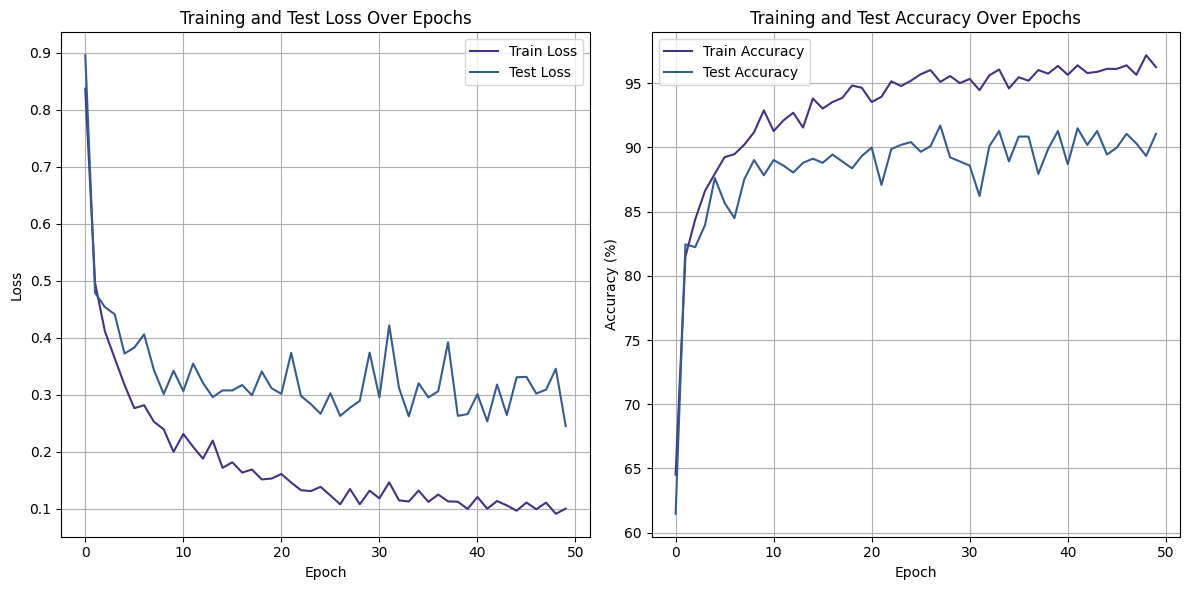

In [ ]:
train_accuary_np = [x.cpu().numpy() for x in train_accuary_list]
test_accuary_np = [x.cpu().numpy() for x in test_accuary_list]

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuary_np, label='Train Accuracy')
plt.plot(test_accuary_np, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

***Model Evaluation***

In [ ]:
y_true = []
y_pred = []

for data in test_loader:
    image,label=data[0].to(device),data[1]
    y_true.extend(label.numpy())

    outputs=model(image)

    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy())

***Confusion matrix and Classification Reports***

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       266
           1       0.87      0.90      0.88       277
           2       0.94      0.87      0.91       151
           3       0.94      0.93      0.93       235

    accuracy                           0.91       929
   macro avg       0.91      0.90      0.91       929
weighted avg       0.91      0.91      0.91       929



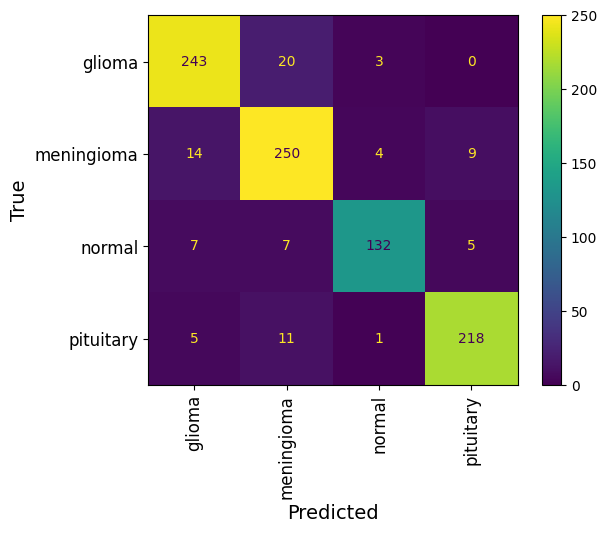

In [ ]:
class_labels = ['glioma', 'meningioma', 'normal', 'pituitary']

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

sns.set_palette("viridis")

disp.plot(cmap=plt.cm.viridis, values_format='.4g', xticks_rotation="vertical", ax=plt.gca())

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)

print(classification_report(y_true, y_pred))

plt.show()

On comparing with the model trained from scratch and model trained from pre-trained  weights with the same architecture, we observed that the model with the pre-trained weights minimized the test loss to a better extent with a higher testing accuraccy.

In [ ]:
from google.colab import files
files.download("best_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("best_model_imagenet.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Question 2***

Build an LSTM-based model for time-series forecasting using PyTorch. Given a series of data points, the model should be able to predict the next data point. You should use the Amazon Stock dataset for this task, where the aim is to use the previous data points to predict the next stock value.

##### ***(a)***

*We will only use the "close" column to train our model, hence you should remove the remaining columns from the dataset. Additionally, since our prediction is based on the historical trend, each data point (each row) in the dataset should be in the form of sequence $->$ prediction. Assume we want to use a sequence window of size 10 in this problem. Preprocess the dataset such that each sequence of 10 values is used to predict the 11th value. You can refer to this article for some examples on how to preprocess the data into sequences. (hint: if your original dataset has 100 data points, then the preprocessed dataset would have $100-10=90$ data points/sequences).*

***Libraries***

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!gdown 1J_K5vc2c_OmMN4ghd8YDHL9OWJsfXRHt
data = pd.read_csv('AMZN.csv')

data = data[['Close']]

scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length]['Close'].values
        label = data.iloc[i+sequence_length]['Close']
        sequences.append(torch.tensor(seq, dtype=torch.float32))
        labels.append(torch.tensor(label, dtype=torch.float32))
    return sequences, labels

sequence_length = 10

sequences, labels = create_sequences(data, sequence_length)

dataset = TensorDataset(torch.stack(sequences), torch.stack(labels))
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)


Downloading...
From: https://drive.google.com/uc?id=1J_K5vc2c_OmMN4ghd8YDHL9OWJsfXRHt
To: /content/AMZN.csv
100% 445k/445k [00:00<00:00, 104MB/s]


##### ***(b)***

*Preprocess the data using the MinMaxScaler from scikit-learn. There is no need to split or shuffle the data for this question.*

In [ ]:
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

##### ***(c)***

*Train a vanilla LSTM to forecast the price of amazon stock based on the last 10 values. You can refer to this article for some guidance. You are free to choose and optimize the hyperparameters (optimizer, batch size, etc), but you should use the MSE loss. Aim for better performance.*

In [ ]:
# Define the LSTM model
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VanillaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(2))
        out = self.fc(out[:, -1, :])
        return out

# Set model parameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

# Initialize the model, loss function, and optimizer
model = VanillaLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_inputs, batch_labels in tqdm(data_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')

Epoch 1/20: 100%|██████████| 102/102 [00:01<00:00, 100.50it/s]


Epoch 1/20, Loss: 0.004578888547785829


Epoch 2/20: 100%|██████████| 102/102 [00:00<00:00, 125.01it/s]


Epoch 2/20, Loss: 0.061376882847456744


Epoch 3/20: 100%|██████████| 102/102 [00:00<00:00, 123.80it/s]


Epoch 3/20, Loss: 0.05930388545193726


Epoch 4/20: 100%|██████████| 102/102 [00:01<00:00, 98.43it/s]


Epoch 4/20, Loss: 0.01758648508720795


Epoch 5/20: 100%|██████████| 102/102 [00:01<00:00, 88.89it/s]


Epoch 5/20, Loss: 0.01238620494630185


Epoch 6/20: 100%|██████████| 102/102 [00:01<00:00, 88.38it/s]


Epoch 6/20, Loss: 0.006163328338028109


Epoch 7/20: 100%|██████████| 102/102 [00:01<00:00, 92.56it/s]


Epoch 7/20, Loss: 0.004348153239254102


Epoch 8/20: 100%|██████████| 102/102 [00:00<00:00, 125.21it/s]


Epoch 8/20, Loss: 0.004902959852705663


Epoch 9/20: 100%|██████████| 102/102 [00:00<00:00, 112.06it/s]


Epoch 9/20, Loss: 0.0017862160383736087


Epoch 10/20: 100%|██████████| 102/102 [00:00<00:00, 122.13it/s]


Epoch 10/20, Loss: 0.0013043989007004997


Epoch 11/20: 100%|██████████| 102/102 [00:00<00:00, 125.10it/s]


Epoch 11/20, Loss: 0.0015061229497061446


Epoch 12/20: 100%|██████████| 102/102 [00:00<00:00, 125.18it/s]


Epoch 12/20, Loss: 0.0014022512770738968


Epoch 13/20: 100%|██████████| 102/102 [00:00<00:00, 124.50it/s]


Epoch 13/20, Loss: 0.0013195640136421263


Epoch 14/20: 100%|██████████| 102/102 [00:00<00:00, 124.62it/s]


Epoch 14/20, Loss: 0.0013254804432557533


Epoch 15/20: 100%|██████████| 102/102 [00:00<00:00, 121.92it/s]


Epoch 15/20, Loss: 0.0014086209034981129


Epoch 16/20: 100%|██████████| 102/102 [00:00<00:00, 118.80it/s]


Epoch 16/20, Loss: 0.0015819715708100073


Epoch 17/20: 100%|██████████| 102/102 [00:00<00:00, 128.03it/s]


Epoch 17/20, Loss: 0.0018282872746223186


Epoch 18/20: 100%|██████████| 102/102 [00:00<00:00, 126.64it/s]


Epoch 18/20, Loss: 0.0020024768194197547


Epoch 19/20: 100%|██████████| 102/102 [00:00<00:00, 107.66it/s]


Epoch 19/20, Loss: 0.0019090246035721812


Epoch 20/20: 100%|██████████| 102/102 [00:01<00:00, 86.24it/s]

Epoch 20/20, Loss: 0.0016216633851786578


##### ***(d)***

*Analyze the performance of your model by plotting the training loss. Using the available data, compare the original plot of the data points with the predicted plot (each data point on the predicted plot is obtained by feeding the previous 10 data points from the original data).*

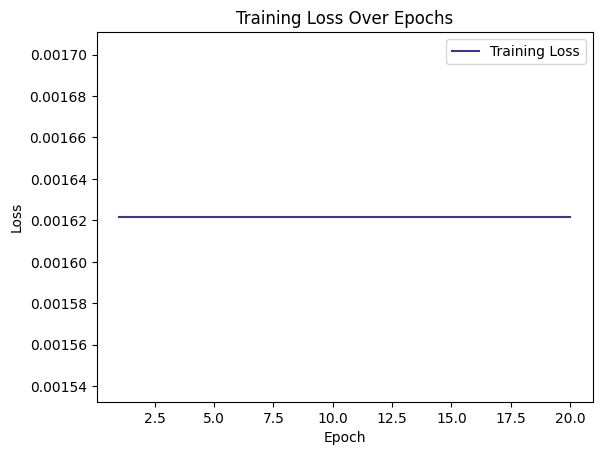

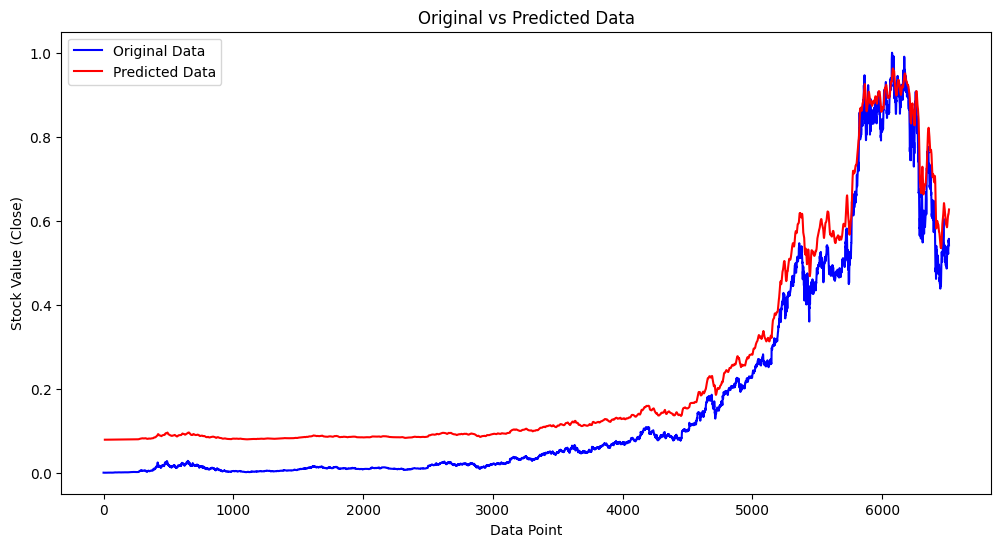

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for i in range(len(sequences)):
        input_sequence = sequences[i].unsqueeze(0)  # one sequence
        output = model(input_sequence)
        predictions.append(output.item())

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

original_data = scaler.inverse_transform(data['Close'].values.reshape(-1, 1)).flatten()

# Plot the training loss
plt.plot(range(1, num_epochs + 1), [average_loss] * num_epochs, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot the original data and predicted data
plt.figure(figsize=(12, 6))
plt.plot(original_data, label='Original Data', color='blue')
plt.plot(range(sequence_length, len(data)), predictions, label='Predicted Data', color='red')
plt.xlabel('Data Point')
plt.ylabel('Stock Value (Close)')
plt.title('Original vs Predicted Data')
plt.legend()
plt.show()

# ***Question 3***

*In this question, you are tasked with implementing color clustering for an image using k-means from scikit-learn. Consider the following image of a bird (you have to use the original "bird.png" image attached with the assignment files):*

***Libraries***

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_colour_space(RGB, title=None, hold=False, **kwargs):
    """
    Plots Nx3 matrix RGB in 3 dimensions.

    The keyword arguments are passed to Matplotlib's scatter() function.
    If hold=True, the points will be added to the previous plot. Otherwise a new plot is generated.
    """
    if hold:
        ax = plt.gca()
    else:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
    kwargs.setdefault('alpha', 1.0)
    ax.scatter(*RGB.T, **kwargs)
    ax.set_xlabel('R', color='r', fontweight='bold', fontsize=15)
    ax.set_ylabel('G', color='g', fontweight='bold', fontsize=15)
    ax.set_zlabel('B', color='b', fontweight='bold', fontsize=15)
    if title is not None:
        ax.set_title(title)

# plot_colour_space(RGB, c=RGB, s=0.5, marker='s', title="Pixels plotted in colour space")

In [3]:
!gdown 1gNOl2moIYf79qMO-0gMkibYqTfMegEb9
image_path = '/content/bird.png'
image = plt.imread(image_path)

Downloading...
From: https://drive.google.com/uc?id=1gNOl2moIYf79qMO-0gMkibYqTfMegEb9
To: /content/bird.png
100% 386k/386k [00:00<00:00, 103MB/s]


In [4]:
# (a) normalize the image
def normalize_image(image):
    max_value = np.max(image)
    normalized_image = image / max_value
    return normalized_image

Text(0.5, 1.0, 'original normalized Image')

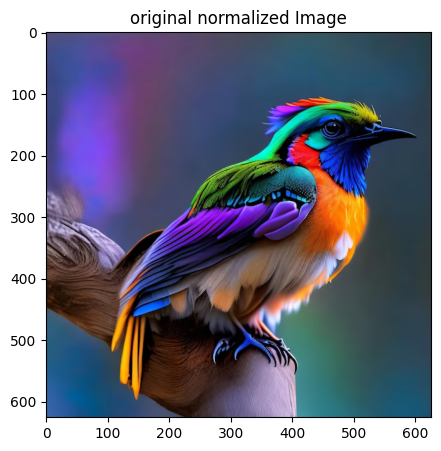

In [7]:
# (b) original normalized image and color spaces of it
normalized_image = normalize_image(image)
plt.figure(figsize=(10, 5))
# plt.imshow(cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB))
plt.imshow(normalized_image)
plt.title('original normalized Image')

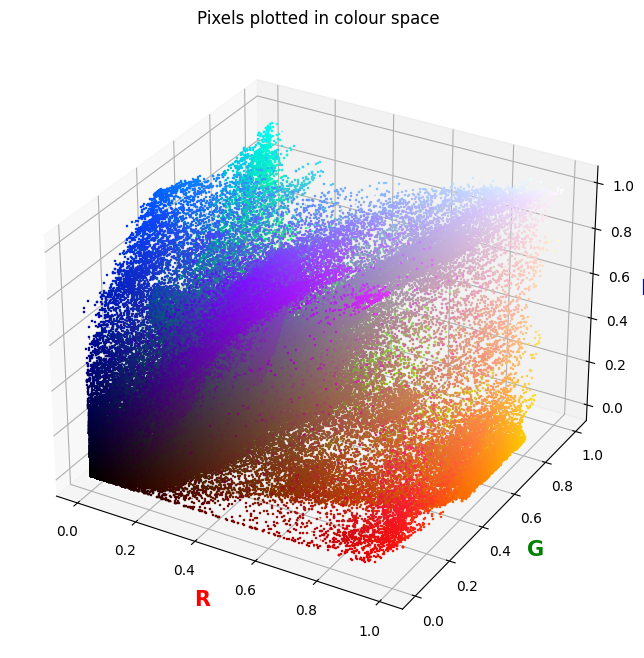

In [8]:
RGB = image.reshape(-1, 3)
plot_colour_space(RGB, c=RGB, s=0.5, marker='s', title="Pixels plotted in colour space")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


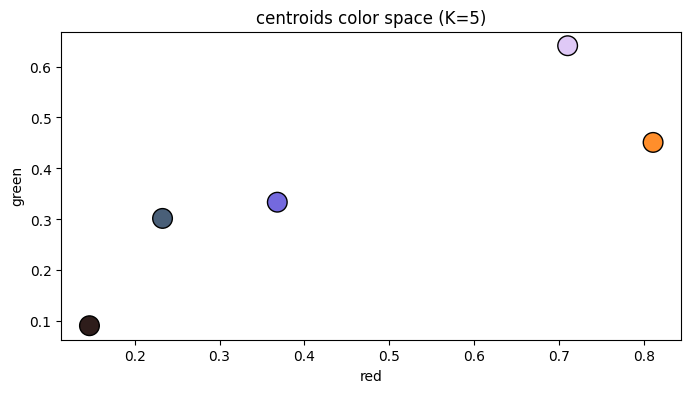

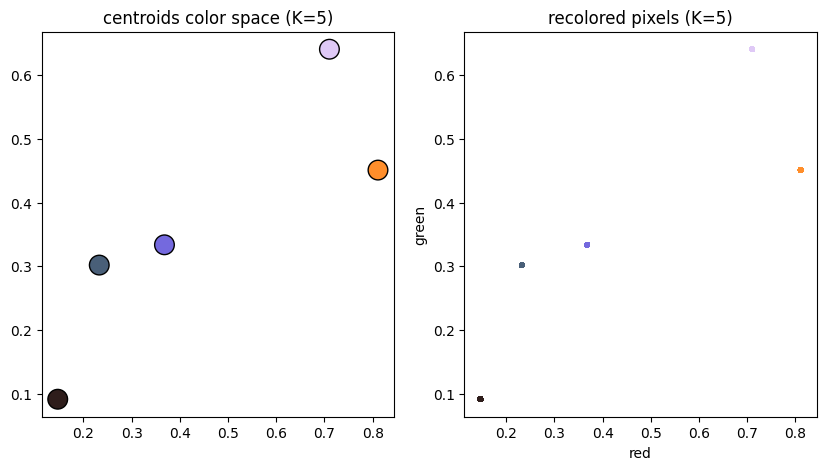

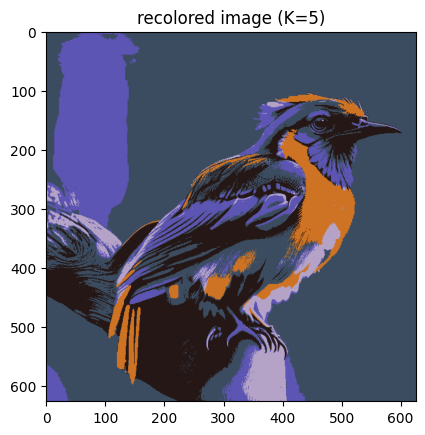

MSE (K=5): 0.010780907236039639


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


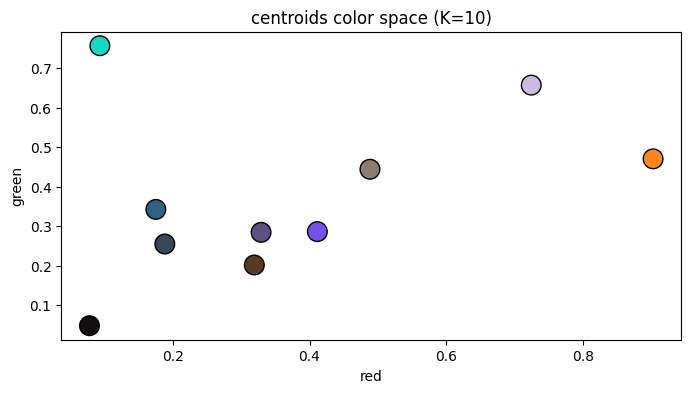

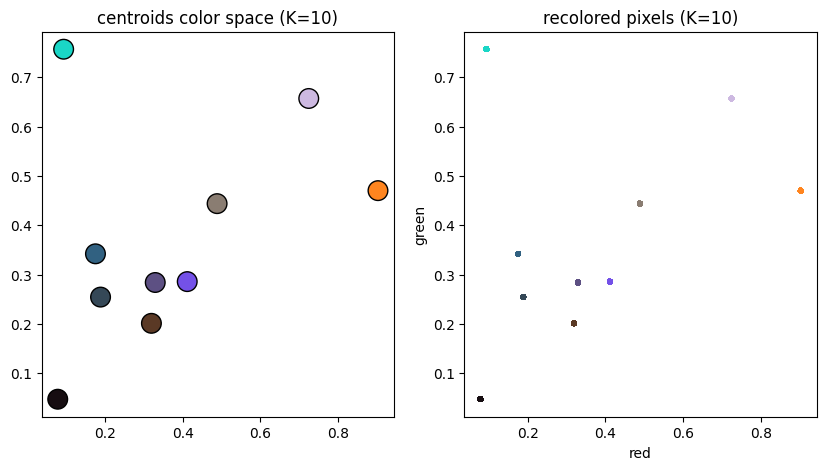

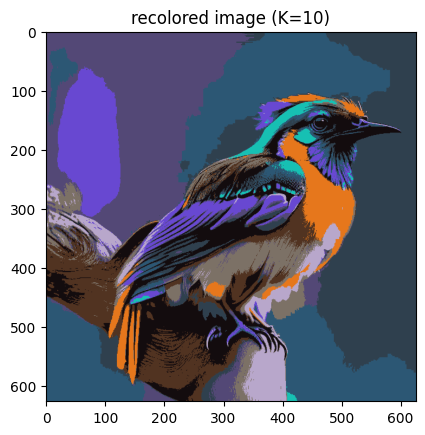

MSE (K=10): 0.005877843592315912


In [10]:
# (c) k-means clustering with K=5 and K=10
k_values = [5, 10]

for k in k_values:
    pixels = normalized_image.reshape((-1, 3))

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    plt.figure(figsize=(8, 4))
    plt.scatter(centroids[:, 0], centroids[:, 1], c=centroids / centroids.max(), marker='o', s=200, edgecolors='k')
    plt.title(f'centroids color space (K={k})')
    plt.xlabel('red')
    plt.ylabel('green')
    plt.show()

    # (d) recolor the image according to the centroids
    recolored_pixels = centroids[labels].reshape(normalized_image.shape)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=centroids / centroids.max(), marker='o', s=200, edgecolors='k')
    plt.title(f'centroids color space (K={k})')

    plt.subplot(1, 2, 2)
    plt.scatter(recolored_pixels[:, :, 0].flatten(), recolored_pixels[:, :, 1].flatten(),
                c=recolored_pixels.reshape((-1, 3)) / recolored_pixels.max(), marker='.')
    plt.title(f'recolored pixels (K={k})')
    plt.xlabel('red')
    plt.ylabel('green')
    plt.show()

    # (e) the recolored image
    plt.imshow(recolored_pixels)
    plt.title(f'recolored image (K={k})')
    plt.show()

    # (f)MSE between the original normalized image and the recolored image
    mse = mean_squared_error(normalized_image.flatten(), recolored_pixels.flatten())
    print(f'MSE (K={k}): {mse}')

# Question 4

*Consider the lung cancer prediction dataset available on Kaggle, used for a classification task to determine if the patient has cancer or not. You are required to use scikit-learn for the ML models in the following questions.*

In [15]:
!gdown 1g90pSqaE6WwEHTuaaRWAKVaUBBVu4jit

Downloading...
From: https://drive.google.com/uc?id=1g90pSqaE6WwEHTuaaRWAKVaUBBVu4jit
To: /content/survey lung cancer.csv
100% 11.3k/11.3k [00:00<00:00, 20.7MB/s]


***Libraries***

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
# (a) Load and preprocess the data
data = pd.read_csv('/content/survey lung cancer.csv')


X = data.drop('LUNG_CANCER', axis=1)
y = data['LUNG_CANCER']

# Convert textual features into numerical values using Label Encoding
label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# (b) Train a K-nearest neighbors (KNN) model
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)

# Evaluate the model on training set
y_train_pred_knn = knn_model.predict(X_train)
print("KNN - Training Set:")
print(classification_report(y_train, y_train_pred_knn))

# Evaluate the model on testing set
y_test_pred_knn = knn_model.predict(X_test)
print("KNN - Testing Set:")
print(classification_report(y_test, y_test_pred_knn))

# (c) Train a Support Vector Machine (SVM) model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Evaluate the model on training set
y_train_pred_svm = svm_model.predict(X_train)
print("SVM - Training Set:")
print(classification_report(y_train, y_train_pred_svm))

# Evaluate the model on testing set
y_test_pred_svm = svm_model.predict(X_test)
print("SVM - Testing Set:")
print(classification_report(y_test, y_test_pred_svm))

# (d) Train a Gaussian Naive Bayes (GaussianNB) model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Evaluate the model on training set
y_train_pred_nb = nb_model.predict(X_train)
print("Gaussian Naive Bayes - Training Set:")
print(classification_report(y_train, y_train_pred_nb))

# Evaluate the model on testing set
y_test_pred_nb = nb_model.predict(X_test)
print("Gaussian Naive Bayes - Testing Set:")
print(classification_report(y_test, y_test_pred_nb))

# (e) Train a Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Evaluate the model on training set
y_train_pred_dt = dt_model.predict(X_train)
print("Decision Tree - Training Set:")
print(classification_report(y_train, y_train_pred_dt))

# Evaluate the model on testing set
y_test_pred_dt = dt_model.predict(X_test)
print("Decision Tree - Testing Set:")
print(classification_report(y_test, y_test_pred_dt))

# (f) Train an AdaBoost model
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train, y_train)

# Evaluate the model on training set
y_train_pred_adaboost = adaboost_model.predict(X_train)
print("AdaBoost - Training Set:")
print(classification_report(y_train, y_train_pred_adaboost))

# Evaluate the model on testing set
y_test_pred_adaboost = adaboost_model.predict(X_test)
print("AdaBoost - Testing Set:")
print(classification_report(y_test, y_test_pred_adaboost))


KNN - Training Set:
              precision    recall  f1-score   support

          NO       0.50      0.12      0.20        32
         YES       0.87      0.98      0.92       184

    accuracy                           0.85       216
   macro avg       0.68      0.55      0.56       216
weighted avg       0.81      0.85      0.81       216

KNN - Testing Set:
              precision    recall  f1-score   support

          NO       1.00      0.14      0.25         7
         YES       0.93      1.00      0.97        86

    accuracy                           0.94        93
   macro avg       0.97      0.57      0.61        93
weighted avg       0.94      0.94      0.91        93

SVM - Training Set:
              precision    recall  f1-score   support

          NO       0.00      0.00      0.00        32
         YES       0.85      1.00      0.92       184

    accuracy                           0.85       216
   macro avg       0.43      0.50      0.46       216
weighted avg   